---

Швецов Д.А. ИСУ: 285659

---

#Сетап

In [1]:
# !sudo apt-get update #linux
# !sudo apt-get install -y xvfb python3-opengl #colab
# !pip install pyvirtualdisplay #colab
# !pip install gym[classic_control]

In [2]:
import matplotlib.pyplot as plt
# import numpy as np
%matplotlib inline

from IPython import display
# from pyvirtualdisplay import Display
# d = Display(visible=0, size=(400, 300))
# d.start()

def show_state(env, episode=0, step=0, info=""):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render())#mode='rgb_array'))
    plt.title("%s | Eposide: %d | Step: %d %s" % ('Cart-pole-v1', episode, step, info))
    plt.axis('off')

    display.clear_output(wait=True)
    display.display(plt.gcf())

In [3]:
import copy
import torch
# from torch import distributions
from torch.autograd import Variable
# from torch.optim.lr_scheduler import StepLR
import random
# import math
# import torchvision.transforms as T
import numpy as np
# import time
import gymnasium as gym

#Лаб. 5. Добавление Target Network в Deep Q Network

##DQN

In [4]:
class DQN():
  def __init__(self, state_dim, action_dim, hidden_dim=12,alpha=0.001):
    self.criterion=torch.nn.MSELoss()
    self.model=torch.nn.Sequential(
        torch.nn.Linear(state_dim,hidden_dim),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(hidden_dim,2*hidden_dim),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(2*hidden_dim,action_dim)
    ).to(device)
    self.optimizer=torch.optim.Adam(self.model.parameters(),alpha)
    # self.scheduler=StepLR(self.optimizer,step_size=1,gamma=0.95)#.5
    self.scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer,factor=0.7,patience=10)
    self.scheduler0=torch.optim.lr_scheduler.CosineAnnealingLR(self.optimizer, 300//10)

  def update(self, state,y):
    y_pred=self.model(state)#torch.Tensor(state).to(device))
    loss=self.criterion(y_pred, Variable(torch.Tensor(y)))#Variable(torch.Tensor(y).to(device)))
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()

  def predict(self, state):
    with torch.no_grad():
      # print(f'state {state}, {state.shape}')
      return self.model(state)#torch.Tensor(state).to(device))

  def replay(self, tmodel, memory, replay_size, gamma):
      if len(memory) < replay_size:
        return

      batch = random.sample(memory, replay_size)

      batch_t = list(map(list, zip(*batch)))
      states = batch_t[0]
      actions = batch_t[1]
      next_states = batch_t[2]
      rewards = batch_t[3]
      is_done = batch_t[4]

      states = torch.Tensor(states).to(device)
      actions = torch.LongTensor(actions).to(device)
      next_states = torch.Tensor(next_states).to(device)
      rewards = torch.Tensor(rewards).to(device)
      is_dones_tensor = torch.Tensor(is_done).to(device)

      is_done_indices = torch.where(is_dones_tensor==True)[0]

      #predict q_values
      all_q_values = self.model(states)
      all_q_values_next = tmodel.model(next_states)

      #update q_values
      all_q_values[range(len(all_q_values)), actions] = rewards + gamma*torch.max(all_q_values_next, axis=1).values
      all_q_values[is_done_indices.tolist(), actions[is_done].tolist()] = rewards[is_done_indices.tolist()]

      # self.update(states.tolist(), all_q_values)
      self.update(states, all_q_values)

###Пайплайн обучения

In [5]:
# env = gym.make('CartPole-v0')

# n_states = 4
# n_actions = 2

# # Learning Parameters
# epsilon = 0.9#0.9 # gready threashold
# alpha = 0.01 # learning rate
# gamma = 0.99 # reward discount factor

# agent = DQN(n_states,n_actions, hidden_dim=12,alpha=alpha)
# memory = []
# replay_size = 100

# # Execution parameters
# SHOW_ANIMATION = False
# EPISODES_MAX = 300
# STEPS_MAX = 250
# DESIRED_STEPS = 250

# # Loggers
# log_steps_number = np.zeros(EPISODES_MAX)
# fails_by_cart_pos = 0
# fails_by_pole_angle = 0
# fails_both = 0

# # Q-learning
# for i_episode in range(EPISODES_MAX):

#     state = env.reset()
#     # state = get_state(observation, n_buckets, state_bounds)

#     # show results
#     if (i_episode + 1) % 10 == 0:
#         plt.figure(1)
#         plt.clf()
#         plt.plot([0,i_episode], [195, 195], label="threshold")
#         plt.plot(range(0,i_episode), log_steps_number[0:i_episode], label="solution 1")
#         plt.xlabel('episode')
#         plt.ylabel('episode steps')
#         plt.legend()
#         plt.title('epsilon={} alpha={}'.format(epsilon, agent.scheduler.get_last_lr()[0]))
#         display.clear_output(wait=True)
#         display.display(plt.gcf())

#     if (i_episode + 1) % 10 == 0: #10
#         epsilon = epsilon*0.85 #0.85
#         # alpha = alpha*0.9

#     if (i_episode + 1) % 30 == 0: #50
#         agent.scheduler.step()
#         # alpha = alpha*0.85

#     for t in range(STEPS_MAX):
#         # env.render()
#         if SHOW_ANIMATION or (i_episode > 0.9*EPISODES_MAX and t > 0.95*DESIRED_STEPS):
#             show_state(env.env, i_episode, t)

#         q_values = agent.predict(state)
#         if np.random.random_sample() < epsilon:
#             action = env.action_space.sample()
#         else:
#             action = torch.argmax(q_values).item()

#         next_state, reward, done, info = env.step(action)
#         memory.append((state, action, next_state, reward,done))

#         if done:
#             #update qnetwork
#             q_values[action] = reward
#             agent.update(state, q_values)

#             log_steps_number[i_episode] = t;
#             break


#         if len(memory) < replay_size:
#             #update qnetwork
#             q_values_next = agent.predict(next_state)
#             q_values[action] = reward + gamma*torch.amax(q_values_next)
#             agent.update(state, q_values)
#         else:
#             agent.replay(agent,memory,replay_size,gamma)

#         #update current state
#         state = next_state

# print("done")
# print("{} {} {}".format(fails_by_cart_pos, fails_by_pole_angle, fails_both))

In [6]:
# # Q-learning
# for i_episode in range(EPISODES_MAX):

#     state = env.reset()

#     # show results
#     if (i_episode + 1) % 100 == 0:
#         plt.figure(1)
#         plt.clf()
#         plt.plot([0,i_episode], [195, 195], label="threshold")
#         plt.plot(range(0,i_episode), log_steps_number[0:i_episode], label="solution 1")
#         plt.xlabel('episode')
#         plt.ylabel('episode steps')
#         plt.legend()
#         # plt.title('epsilon={} alpha={}'.format(epsilon,alpha))
#         plt.title('epsilon={} alpha={}'.format(epsilon, agent.scheduler.get_last_lr()[0]))
#         display.clear_output(wait=True)
#         display.display(plt.gcf())

#     for t in range(STEPS_MAX):
#         # env.render()
#         if SHOW_ANIMATION or (i_episode > 0.9*EPISODES_MAX and t > 0.95*DESIRED_STEPS):
#             show_state(env.env, i_episode, t)

#         q_values = agent.predict(state)

#         action = torch.argmax(q_values).item()

#         next_state, reward, done, info = env.step(action)
#         memory.append((state, action, next_state, reward,done))

#         if done:
#             log_steps_number[i_episode] = t;
#             break

#         #update current state
#         state = next_state

# print("done")
# print("{} {} {}".format(fails_by_cart_pos, fails_by_pole_angle, fails_both))

##Target Network

In [7]:
class TNDQN:
  def __init__(self, dqn):
    self.model = copy.deepcopy(dqn.model).to(device)
  def  update(self,dqn):
    parameters = dqn.model.state_dict()
    self.model.load_state_dict(parameters)

  def predict(self, state): #for next state
    with torch.no_grad():
      return self.model(state)#torch.Tensor(state).to(device))

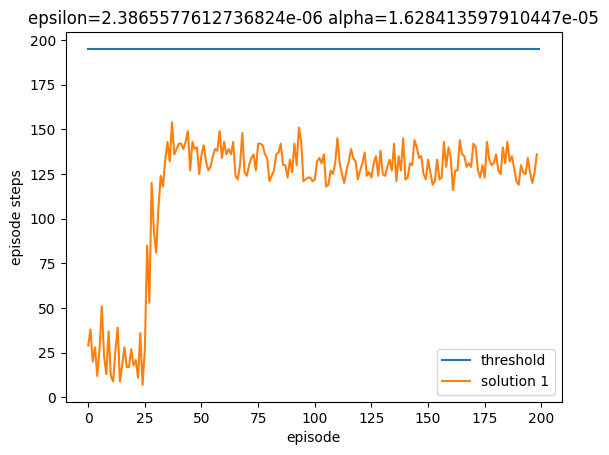

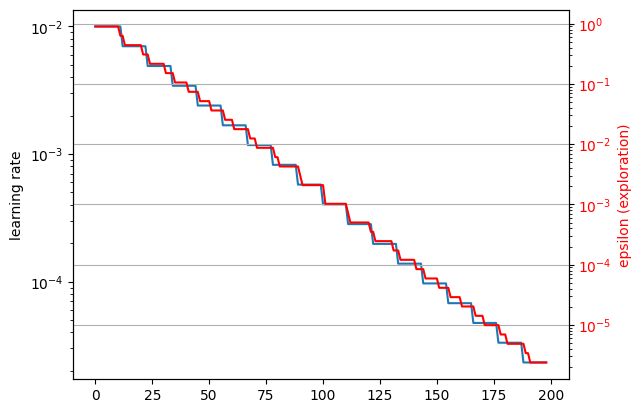

In [9]:
from gymnasium.envs.registration import make, pprint_registry, register, registry, spec

# register(
#     id="Hopper-v8",
#     entry_point="gym_template:HopperEnv8",
#     max_episode_steps=1000,
#     reward_threshold=3800.0,
# )
# env = gym.make('Hopper-v8', render_mode='rgb_array')
env = gym.make('CartPole-v0', render_mode='rgb_array')

device = "cpu"
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

n_states = 4
n_actions = 2

# Learning Parameters
epsilon = 0.9#0.9 # gready threashold
alpha = 0.01 # learning rate
gamma = 0.99 # reward discount factor
consec_wins = 14

agent2 = DQN(n_states,n_actions, hidden_dim=8,alpha=alpha)
tmodel = TNDQN(agent2)

memory = []
replay_size = 30

# Execution parameters
SHOW_ANIMATION = False
EPISODES_MAX = 200#300
STEPS_MAX = 250
DESIRED_STEPS = 250

# Loggers
log_steps_number = np.zeros(EPISODES_MAX)
fails_by_cart_pos = 0
fails_by_pole_angle = 0
fails_both = 0

lrs = []
eps = []
succ_count = 0
eps_coef = epsilon/alpha

# Q-learning
for i_episode in range(EPISODES_MAX):

    state = env.reset()[0]
    stateT = torch.Tensor(state).to(device)
    # print(f'state {state}')

    lrs.append(agent2.scheduler.get_last_lr()[0])
    eps.append(epsilon)

    if log_steps_number[i_episode-1] == 199:
      succ_count += 1
    else:
      succ_count = 0

    # show results
    if (i_episode + 1) % 10 == 0 or succ_count > consec_wins:
        # plt.figure(1)
        plt.clf()
        plt.plot([0,i_episode], [195, 195], label="threshold")
        plt.plot(range(0,i_episode), log_steps_number[0:i_episode], label="solution 1")
        plt.xlabel('episode')
        plt.ylabel('episode steps')
        plt.legend()
        plt.title('epsilon={} alpha={}'.format(epsilon, agent2.scheduler.get_last_lr()[0]))
        # display.clear_output(wait=True)
        # display.display(plt.gcf())

        plt.figure()
        # fig, ax1 = plt.subplots()
        ax1 = plt.gca()
        plt.yscale('log')
        ax2 = ax1.twinx()
        plt.yscale('log')

        ax1.plot(range(0,i_episode), lrs[0:i_episode])
        plt.xlabel('episode')
        ax1.set_ylabel('learning rate')
        ax2.plot(range(0,i_episode), eps[0:i_episode],'r-')
        ax2.set_ylabel('epsilon (exploration)', color='r')
        ax2.tick_params(axis='y', labelcolor='r')
        # ax1.yscale('log')
        # ax2.yscale('log')
        ax2.grid()

        display.clear_output(wait=True)

        plt.show()

    if succ_count > consec_wins:
      break

    epsilon = eps_coef* agent2.scheduler.get_last_lr()[0]

    # if i_episode +1 == 140:
    #     epsilon = 0.00001

    # if (i_episode + 1) % 40 == 0: #10
    #       epsilon = epsilon*0.45 #85
    #       # alpha = alpha*0.9

    if (i_episode + 1) % 10 == 0: #10
      # epsilon = epsilon*0.7 #85
      eps_coef *= 0.7

    if log_steps_number[i_episode-1] == 199:
      eps_coef *= 0.5


    # if log_steps_number[i_episode-1] > 195:
    #   succ_count += 1
    #   if succ_count > 10:
    #     epsilon = epsilon*0.5

    # if i_episode +1 < 140:
    #   if (i_episode + 1) % 10 == 0: #10
    #       epsilon = epsilon*0.35 #85
    #       # alpha = alpha*0.9
    # else:
    #     epsilon = 0.00001


    if (i_episode + 1) % 5 == 0: #10
        tmodel.update(agent2)

    # if (i_episode + 1) % 30 == 0:#30 #50
    #     agent2.scheduler0.step()
        # if (i_episode + 1) > 150:
        #   agent2.scheduler0.step()

    # if (i_episode + 1) > 150:
    #   agent2.scheduler0.step()
    # if (i_episode + 1) > 150 and (i_episode + 1) < 200:
    #   agent2.scheduler.step()

    # if (i_episode + 1) < 150:
    #   agent2.scheduler0.step()
    #   if (i_episode + 1) > 80: #180
    #     agent2.scheduler.step()
    agent2.scheduler.step(log_steps_number[i_episode-1])


    for t in range(STEPS_MAX):
        # env.render()
        if SHOW_ANIMATION or (i_episode > 0.9*EPISODES_MAX and t > 0.95*DESIRED_STEPS):
            show_state(env.env, i_episode, t)

        q_values = agent2.predict(stateT)
        if np.random.random_sample() < epsilon:
            action = env.action_space.sample()
        else:
            action = torch.argmax(q_values).item()

        next_state, reward, terminated, truncated, info = env.step(action)
        next_stateT = torch.Tensor(next_state).to(device)
        done = terminated or truncated
        memory.append((state, action, next_state, reward,done))

        if done:
            log_steps_number[i_episode] = t;
            break

        if len(memory) < replay_size:
            agent2.replay(tmodel,memory,int(len(memory)/2)+1,gamma)
        else:
            agent2.replay(tmodel,memory,replay_size,gamma)

        #update current state
        state = next_state
        stateT = next_stateT

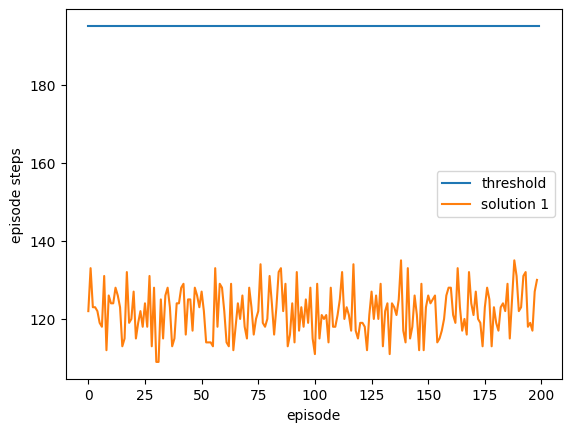

done
0 0 0


In [11]:
# Q-learning
for i_episode in range(EPISODES_MAX):

    state = env.reset()[0]
    stateT = torch.Tensor(state).to(device)

    # show results
    if (i_episode + 1) % 50 == 0:
        # plt.figure(1)
        plt.clf()
        plt.plot([0,i_episode], [195, 195], label="threshold")
        plt.plot(range(0,i_episode), log_steps_number[0:i_episode], label="solution 1")
        plt.xlabel('episode')
        plt.ylabel('episode steps')
        plt.legend()
        # plt.title('epsilon={} alpha={}'.format(epsilon,alpha))
        # plt.title('epsilon={} alpha={}'.format(epsilon, agent2.scheduler.get_last_lr()[0]))
        display.clear_output(wait=True)
        # display.display(plt.gcf())
        plt.show()

    for t in range(STEPS_MAX):
        # env.render()
        if SHOW_ANIMATION or (i_episode > 0.9*EPISODES_MAX and t > 0.95*DESIRED_STEPS):
            show_state(env.env, i_episode, t)

        q_values = agent2.predict(stateT)

        action = torch.argmax(q_values).item()

        next_state, reward, terminated, truncated, info = env.step(action)
        next_stateT = torch.Tensor(state).to(device)
        done = terminated or truncated
        memory.append((state, action, next_state, reward,done))

        if done:
            log_steps_number[i_episode] = t;
            break

        #update current state
        state = next_state
        stateT = next_stateT

print("done")
print("{} {} {}".format(fails_by_cart_pos, fails_by_pole_angle, fails_both))